#Assignment 3: Convolutional NN Model on Solubility#

Aidan Holland, Machine Learning and Molecules

##Introduction##

In this assignment, we use the ESOL dataset to create a predictive model for solubility based on the structure of 1128 different molecules. Whereas before we used only neural networks to create a learning model, here we incorporate convolutional neural networks (CNN), which detect patterns inside of images. The specific method of CNN is GraphConv, which analyzes the molecules in question with elements as nodes and bonds as edges.

##Data Source and Imported Functions##

In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.3/808.3 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 42.2 MB/s eta 0:00:00


'2.7.2.dev'

In [ ]:
import deepchem as dc
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepchem.molnet import load_delaney
from deepchem.splits import RandomSplitter
from deepchem.models.layers import GraphConv, BatchNormalization
from keras.callbacks import EarlyStopping
from deepchem.models import GraphConvModel
from sklearn.metrics import mean_squared_error

##Model Code##

In [ ]:
delaney_tasks, delaney_datasets, transformers = load_delaney(
    featurizer='GraphConv', splitter='random')
train_dataset, valid_dataset, test_dataset = delaney_datasets
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
batch_size= 16
model= GraphConvModel(
    n_tasks = len(delaney_tasks), graph_conv_layers = [32], batch_size=batch_size, batch_normalize= True, dropout = 0.1, mode='regression')

The hyperparameters here, mainly batch size and graph conv layers, have been optimized as well as I could to minimize the train scores and validation scores. The results are not very sensitive to choice of training and test set.

In [ ]:
delaney_tasks

['measured log solubility in mols per litre']

In [ ]:
model.fit(train_dataset, nb_epoch=20)
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
test_scores = model.evaluate(test_dataset, [metric], transformers)
print("Train Scores")
print(train_scores)
print("Validation Scores")
print(valid_scores)
print("Test Scores")
print(test_scores)

Evaluating model
Train Scores
{'mean_squared_error': 1.1000055553443568}
Validation Scores
{'mean_squared_error': 1.5356111988821242}
Test Scores
{'mean_squared_error': 1.673219985918991}


The following code uses the model to minimize our mean squared error or loss through gradient descent. As can be seen in the graph below, the validation and training loss are seen to be decreasing. The printed information before the graph is the model based off the training being used on our validation set.

0 1.4367588712220483
1 1.1348131132507884
2 1.074092687266525
3 0.997280206006249
5 0.8142440545471612
7 0.800741022529632
8 0.7557290690169198


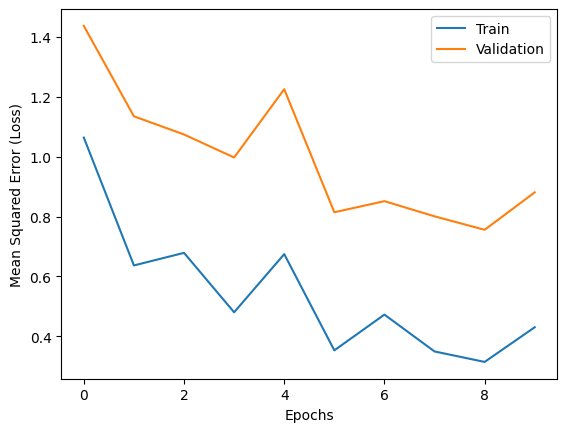

In [ ]:
train_loss = []
valid_loss = []
max_epochs = 10
lowest_val = 1000
patience = 10
k = 0

for i in range(max_epochs):
  model.fit(train_dataset, nb_epoch = 16)
  train_loss_check = model.evaluate(train_dataset, [metric], transformers)
  valid_loss_check = model.evaluate(valid_dataset, [metric], transformers)
  train_loss.append(train_loss_check["mean_squared_error"])
  valid_loss.append(valid_loss_check["mean_squared_error"])
  k += 1
  if valid_loss_check["mean_squared_error"] < lowest_val:
    lowest_val = valid_loss_check["mean_squared_error"]
    print(i, lowest_val)
    k = 0
  if k == patience:
    print("Training stopped at epoch", i)
    break

plt.plot(range(len(train_loss)), train_loss, label = "Train")
plt.plot(range(len(valid_loss)), valid_loss, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (Loss)")
plt.legend()

##Model Analysis Code##

Text(0, 0.5, 'Experimental Solubility')

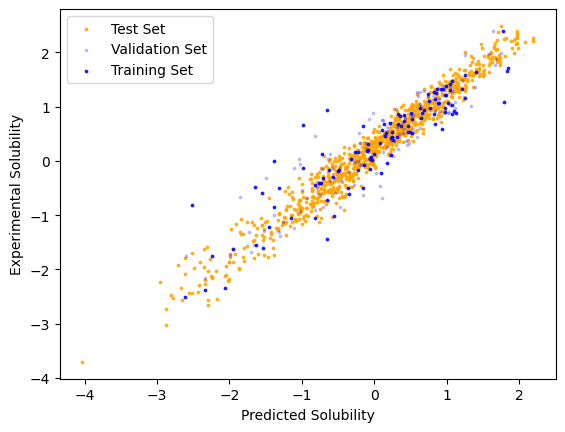

In [ ]:
y_pred_train = model.predict(train_dataset)
y_train = train_dataset.y
plt.scatter(y_train, y_pred_train, label="Test Set", color = 'orange', alpha = 0.8, s=3)

y_pred_valid = model.predict(valid_dataset)
y_valid = valid_dataset.y
plt.scatter(y_valid, y_pred_valid, label = "Validation Set", color = 'blue', alpha = 0.2, s = 3)

y_pred_test = model.predict(test_dataset)
y_test = test_dataset.y
plt.scatter(y_test, y_pred_test, label="Training Set", color = 'blue', alpha = 0.8, s=3)

plt.legend()
plt.xlabel("Predicted Solubility")
plt.ylabel("Experimental Solubility")

An element of GraphConv is transforming the data for proper analysis. This causes us to have data that does not represent the actual solubility of the molecules in question. Therefore, we untransform the data to fix the axes.

Text(0, 0.5, 'Experimental Solubility')

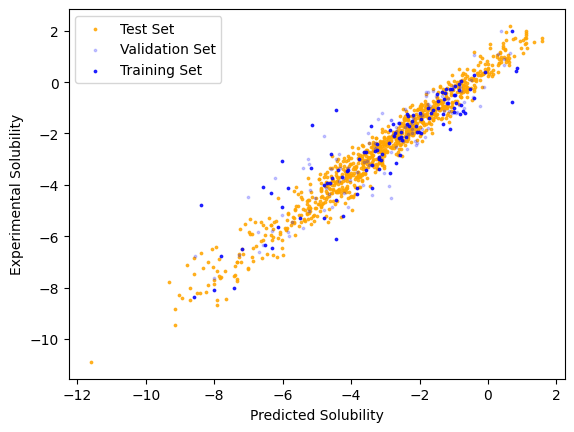

In [ ]:
y_pred_train_act = transformers[0].untransform(y_pred_train)
y_train_act = transformers[0].untransform(y_train)
plt.scatter(y_train_act, y_pred_train_act, label="Test Set", color = 'orange', alpha = 0.8, s=3)

y_pred_valid_act = transformers[0].untransform(y_pred_valid)
y_valid_act = transformers[0].untransform(y_valid)
plt.scatter(y_valid_act, y_pred_valid_act, label="Validation Set", color = 'blue', alpha = 0.2, s=3)

y_pred_test_act = transformers[0].untransform(y_pred_test)
y_test_act = transformers[0].untransform(y_test)
plt.scatter(y_test_act, y_pred_test_act, label="Training Set", color = 'blue', alpha = 0.8, s=3)

plt.legend()
plt.xlabel("Predicted Solubility")
plt.ylabel("Experimental Solubility")

In [ ]:
print("Average Solubility =",np.mean(y_test_act))
print("Standard Deviation =",np.std(y_test_act))

print("Root Mean Squared Error =",np.sqrt(np.mean((y_test_act - y_pred_test_act)**2)))

average_solubility = np.full_like(y_test_act, np.mean(y_train_act))
rmse_null_test = np.sqrt(np.mean((y_test_act - average_solubility)**2))
print("Root Mean Squared Error Null = ", rmse_null_test)

rse = np.sqrt((y_pred_test_act - y_test_act)**2)
y_test_act_squeeze = np.squeeze(np.asarray(y_test_act))
rse_squeeze = np.squeeze(np.asarray(rse))
correlation = np.corrcoef(y_test_act_squeeze, rse_squeeze)
print("Correlation=",correlation[0,1])

Average Solubility = -2.9262389380530975
Standard Deviation = 2.065918772976548
Root Mean Squared Error = 0.9976700405580241
Root Mean Squared Error Null =  2.070730089590286
Correlation= -0.35234498003292025


##Conclusion##

The Root Mean Squared Error at 1 is lower than that of the normal neural network model we created in assignment 2, which had an error of around 1.2. As can be expected, with the higher sophistication of model, convolutional NN worked better.

The RMSE is far lower than the RMSE null. The RMSE null is essentially the same as the SD because both analyze the error from the average solubility with almost the same formula. The RMSE should be significantly lower than the SD so that we can trust the model to predict on a wide range of molecules accurately.

The correlation situation is similar to assignment 2, being weak and negative. It is unreliable given how close it is to 0 at -0.35, but it implies that error tends to decrease as solubility increases.

The model is not sensitive to choices of training and test set.

Because of the difference in models, there is no longer an issue with predicting the same solubility for multiple molecules. This is because convolutional neural networks can better analyze specific molecules rather than having to use a fingerprint that can confuse two to be the same. Instead is the issue of the data needing to be transformed for GraphConv to function, which, as aforementioned, has been corrected.

